In [82]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [83]:
dataset = 'fb15k-237'
pcts = [106,113,122,134,150,175,217,300,550]
models = ['se','transe','rotate','transr']
split = 'test'
trained_model = 'train-test_extended'

datadir = '../data'
ind_config_fname = '{}_hpo_extension'
trans_config_fname = '{}_hpo'
baseline_loc = os.path.join(datadir, 'baselines', 'ComplexInductiveQueries.csv')

savedir = os.path.join(datadir,'figures')
savedir_tables = os.path.join(datadir, 'tables')

In [84]:
model_name_map = {'rotate':'RotatE', 'transe':'TransE', 'se':'SE', 'transr':'TransR'}
model_color_map = {'RotatE':'#FFCAB1', 'TransE':'#69A2B0', 'SE':'#659157', 'TransR':'#E05263', 'NodePiece-QE':'gray', 'Edge-type Heuristic':'#8182AC', 'NodePiece-QE w/ GNN':'#AEAE92'}

In [85]:
dfs = []
missing = []

for pct in pcts:
    for model in models:
        ind_results = os.path.join(datadir, dataset, str(pct), 'complex_results', split, model, ind_config_fname.format(model), 'hpo_best', 'complex_extension_results.csv')
        trans_results = os.path.join(datadir, dataset, str(pct), 'complex_results', split, model, trans_config_fname.format(model), 'hpo_best', 'complex_extension_results.csv')
        ind_best_hpo_loc = os.path.join(datadir, dataset, str(pct), 'models', 'train', model, 'ablation', ind_config_fname.format(model), 'best_pipeline', 'pipeline_config.json')
        trans_best_hpo_loc = os.path.join(datadir, dataset, str(pct), 'models', 'train', model, 'ablation', trans_config_fname.format(model), 'best_pipeline', 'pipeline_config.json')
        if os.path.exists(ind_results):
            df = pd.read_csv(ind_results)
            df['dataset'] = dataset
            df['ratio'] = pct
            df['model'] = model
            df['hpo_type'] = 'inductive'
            if os.path.exists(ind_best_hpo_loc):
                with open(ind_best_hpo_loc, 'r') as f:
                    config = json.load(f)
                    df['alpha'] = config['extension']['alpha']
                    df['embedding_dim'] = config['pipeline']['model_kwargs']['embedding_dim']
                    df['diffusion_iterations'] = config['extension']['diffusion_iterations']
                    df['learning_rate'] = config['pipeline']['optimizer_kwargs']['lr']
                    df['loss'] = config['pipeline']['loss']
                    if 'loss_kwargs' in config['pipeline'] and config['pipeline']['loss'] == 'nssa':
                        df['adversarial_temperature'] = config['pipeline']['loss_kwargs']['adversarial_temperature']
                        df['margin'] = config['pipeline']['loss_kwargs']['margin']
                        df['num_negs_per_pos'] = config['pipeline']['negative_sampler_kwargs']['num_negs_per_pos']
                    
            dfs.append(df)
        else:
            print(ind_results)
            missing.append({'dataset':dataset,
                            'ratio':pct,
                            'model':model,
                            'hpo_type':'inductive'})
        if os.path.exists(trans_results):
            df = pd.read_csv(trans_results)
            df['dataset'] = dataset
            df['ratio'] = pct
            df['model'] = model
            df['hpo_type'] = 'transductive'
            if os.path.exists(trans_best_hpo_loc):
                with open(trans_best_hpo_loc, 'r') as f:
                    config = json.load(f)
                    # df['alpha'] = config['extension']['alpha']
                    df['embedding_dim'] = config['pipeline']['model_kwargs']['embedding_dim']
                    df['learning_rate'] = config['pipeline']['optimizer_kwargs']['lr']
                    df['loss'] = config['pipeline']['loss']
                    if 'loss_kwargs' in config['pipeline'] and config['pipeline']['loss'] == 'nssa':
                        df['adversarial_temperature'] = config['pipeline']['loss_kwargs']['adversarial_temperature']
                        df['margin'] = config['pipeline']['loss_kwargs']['margin']
                        df['num_negs_per_pos'] = config['pipeline']['negative_sampler_kwargs']['num_negs_per_pos']
            dfs.append(df)
        else:
            print(ind_results)
            missing.append({'dataset':dataset,
                            'ratio':pct,
                            'model':model,
                            'hpo_type':'transductive'})
            
dfs = pd.concat(dfs, axis=0)
dfs = dfs.rename(columns={'Value':'H@10'})
dfs['H@10'] *= 100
# rename models
dfs['model'] = dfs['model'].map(model_name_map)
dfs.head()

,Side,Type,Metric,H@10,query_structure,dataset,ratio,model,hpo_type,alpha,embedding_dim,diffusion_iterations,learning_rate,loss,adversarial_temperature,margin,num_negs_per_pos
0,tail,optimistic,z_inverse_harmonic_mean_rank,2138.838648,1p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
1,both,optimistic,z_inverse_harmonic_mean_rank,2138.838648,1p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
2,tail,realistic,z_inverse_harmonic_mean_rank,2138.838776,1p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
3,both,realistic,z_inverse_harmonic_mean_rank,2138.838776,1p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
4,tail,pessimistic,z_inverse_harmonic_mean_rank,2138.838620,1p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0


In [86]:
pd.DataFrame(missing)

""


In [87]:
metric = 'hits_at_10'
side = 'tail'
tp = 'realistic'

In [88]:
msk = ( (dfs['Metric'] == metric) & \
        (dfs['Side'] == side) & \
        (dfs['Type'] == tp) )
dfs_metric = dfs[msk]
dfs_metric

,Side,Type,Metric,H@10,query_structure,dataset,ratio,model,hpo_type,alpha,embedding_dim,diffusion_iterations,learning_rate,loss,adversarial_temperature,margin,num_negs_per_pos
134,tail,realistic,hits_at_10,0.361416,1p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
284,tail,realistic,hits_at_10,0.839078,2p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
434,tail,realistic,hits_at_10,1.748764,3p,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
584,tail,realistic,hits_at_10,1.539617,2i,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
734,tail,realistic,hits_at_10,4.976060,3i,fb15k-237,106,SE,inductive,0.445,32,1004.0,0.096233,nssa,2.0,2.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,tail,realistic,hits_at_10,0.679936,3p,fb15k-237,550,TransR,transductive,NaN,16,NaN,0.075451,crossentropy,NaN,NaN,NaN
584,tail,realistic,hits_at_10,2.533920,2i,fb15k-237,550,TransR,transductive,NaN,16,NaN,0.075451,crossentropy,NaN,NaN,NaN
734,tail,realistic,hits_at_10,2.584612,3i,fb15k-237,550,TransR,transductive,NaN,16,NaN,0.075451,crossentropy,NaN,NaN,NaN
884,tail,realistic,hits_at_10,0.973106,pi,fb15k-237,550,TransR,transductive,NaN,16,NaN,0.075451,crossentropy,NaN,NaN,NaN


In [89]:
baselines = pd.read_csv(baseline_loc)
baselines = baselines[baselines['model'] != 'GNN-QE']
baselines_long = baselines.melt(['pct','model'],['1p','2p','3p','2i','3i','pi','ip'], var_name='query_structure',value_name='H@10').rename(columns={'pct':'ratio'})
baselines_long

,ratio,model,query_structure,H@10
0,550,Edge-type Heuristic,1p,15.8
1,550,NodePiece-QE,1p,16.3
2,550,NodePiece-QE w/ GNN,1p,20.1
3,300,Edge-type Heuristic,1p,20.9
4,300,NodePiece-QE,1p,19.6
...,...,...,...,...
184,113,NodePiece-QE,ip,5.9
185,113,NodePiece-QE w/ GNN,ip,21.1
186,106,Edge-type Heuristic,ip,3.7
187,106,NodePiece-QE,ip,4.5


In [90]:
comp_hpo_type = 'inductive'
dfs_compare = pd.concat([dfs_metric[dfs_metric['hpo_type'] == comp_hpo_type], baselines_long])
dfs_indexed = dfs_compare.set_index(['model','dataset','ratio'])
dfs_indexed['H@101p'] = dfs_indexed[dfs_indexed['query_structure'] == '1p']['H@10']
dfs_indexed['H@10/1p'] = dfs_indexed['H@10'] / dfs_indexed['H@101p']
dfs_compare = dfs_indexed.reset_index()
dfs_indexed = dfs_compare.set_index(['model','dataset','query_structure'])
dfs_indexed['H@10_106'] = dfs_indexed[dfs_indexed['ratio'] == 106]['H@10']
dfs_indexed['H@10/106'] = dfs_indexed['H@10'] / dfs_indexed['H@10_106']
dfs_compare = dfs_indexed.reset_index()

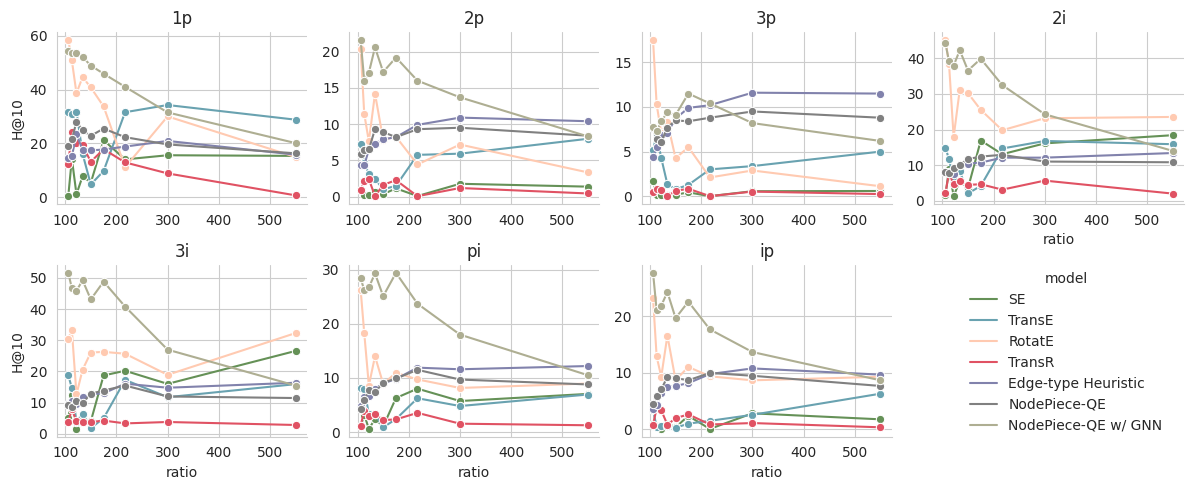

In [91]:
g = sns.relplot(
    data=dfs_compare,
    x="ratio", y="H@10",
    hue="model", col="query_structure", col_wrap=4,
    kind="line", marker="o", facet_kws=dict(sharex=False,sharey=False), palette=model_color_map,
    height=2.5
)
sns.move_legend(g, "lower right", bbox_to_anchor=(.98, .1))
for item, ax in g.axes_dict.items():
    ax.set_title(item) 

plt.tight_layout()
plt.savefig(os.path.join(savedir,f'{comp_hpo_type}_complex_queries.pdf'))

In [92]:
(dfs_compare.set_index(['ratio','model'])
            .sort_index()[['alpha','embedding_dim','diffusion_iterations','learning_rate', 'loss','adversarial_temperature','margin','num_negs_per_pos']]
            .dropna(how='all')
            .drop_duplicates()
            .to_csv(os.path.join(savedir_tables, 'complex_inductive_hyperparameters.csv')))

In [93]:
comp_hpo_type = 'transductive'
dfs_compare = pd.concat([dfs_metric[dfs_metric['hpo_type'] == comp_hpo_type], baselines_long])
dfs_indexed = dfs_compare.set_index(['model','dataset','ratio'])
dfs_indexed['H@101p'] = dfs_indexed[dfs_indexed['query_structure'] == '1p']['H@10']
dfs_indexed['H@10/1p'] = dfs_indexed['H@10'] / dfs_indexed['H@101p']
dfs_compare = dfs_indexed.reset_index()
dfs_indexed = dfs_compare.set_index(['model','dataset','query_structure'])
dfs_indexed['H@10_106'] = dfs_indexed[dfs_indexed['ratio'] == 106]['H@10']
dfs_indexed['H@10/106'] = dfs_indexed['H@10'] / dfs_indexed['H@10_106']
dfs_compare = dfs_indexed.reset_index()

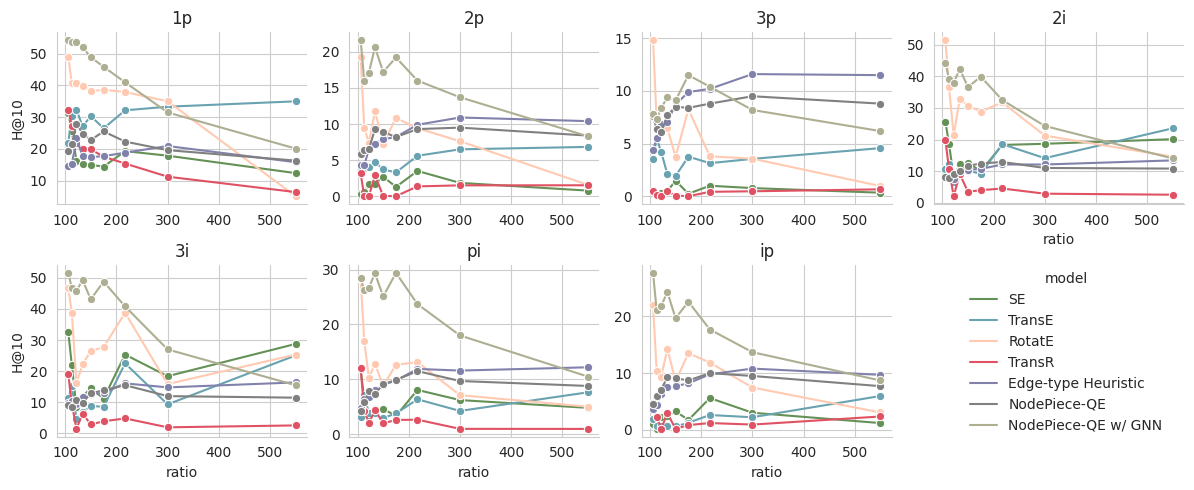

In [94]:
g = sns.relplot(
    data=dfs_compare,
    x="ratio", y="H@10",
    hue="model", col="query_structure", col_wrap=4,
    kind="line", marker="o", facet_kws=dict(sharex=False,sharey=False), palette=model_color_map,
    height=2.5
)
sns.move_legend(g, "lower right", bbox_to_anchor=(.98, .1))
for item, ax in g.axes_dict.items():
    ax.set_title(item) 

plt.tight_layout()
plt.savefig(os.path.join(savedir,f'{comp_hpo_type}_complex_queries.pdf'))

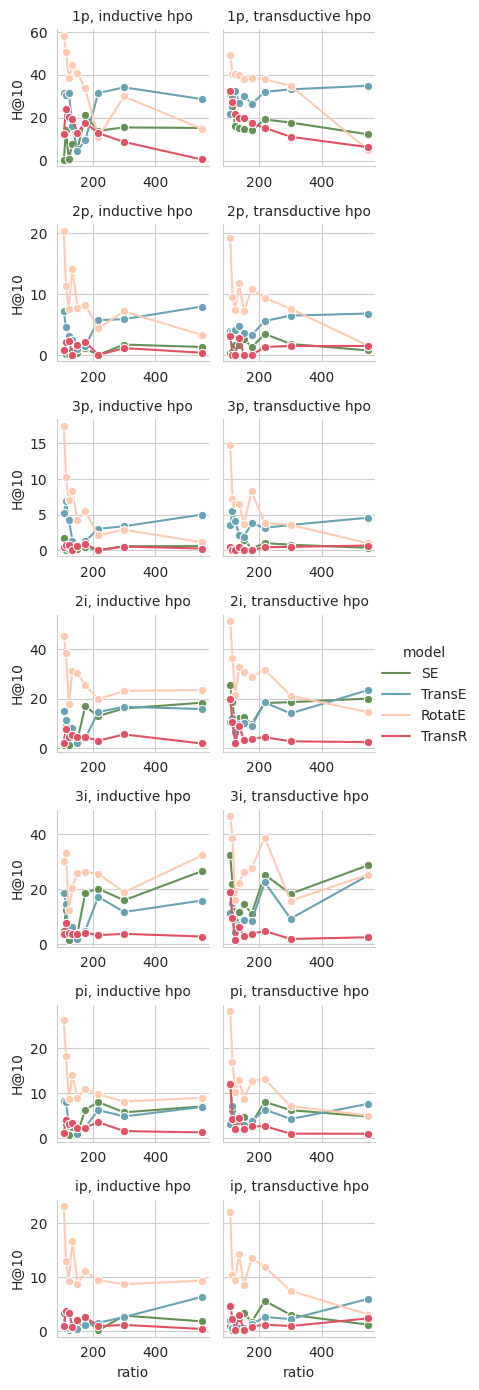

In [95]:
g = sns.relplot(
    data=dfs_metric,
    x="ratio", y="H@10",
    hue="model", col="hpo_type", row="query_structure",
    kind="line", marker="o", facet_kws=dict(sharex=False,sharey='row'), palette=model_color_map,
    height=2
)
sns.move_legend(g, "center right")
for item, ax in g.axes_dict.items():
    ax.set_title(f'{item[0]}, {item[1]} hpo', fontsize=10)
plt.savefig(os.path.join(savedir,f'transductive_vs_inductive_complex_queries.pdf'))

In [96]:
(dfs_compare.pivot(index=['ratio','model'],columns=['query_structure'],values=['H@10'])
            .to_csv(os.path.join(savedir_tables,'complex_queries.csv')))

In [97]:
(dfs_compare.set_index(['ratio','model'])
            .sort_index()[['embedding_dim','learning_rate', 'loss','adversarial_temperature','margin','num_negs_per_pos']]
            .dropna(how='all')
            .drop_duplicates()
            .to_csv(os.path.join(savedir_tables, 'complex_transductive_hyperparameters.csv')))